In [2]:
#!pip install qlearnkit['pennylane']
#!pip install --upgrade scipy pennylane
#!pip install pennylane
#!pip install --upgrade numpy pennylane
#!pip install pennylane-lightning



In [3]:
import torch
import torch.nn as nn
import pennylane as qml
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class QLSTM(nn.Module):

    def custom_encoding(self, inputs, wires):
        # Apply Hadamard to each qubit to create an unbiased initial state
        for wire in range(self.n_qubits):
            qml.Hadamard(wires=wire)

        qml.templates.AngleEmbedding(torch.arctan(inputs), rotation='Y', wires=wires)
        qml.templates.AngleEmbedding(torch.arctan(inputs ** 2), rotation='Z', wires=wires)

    def custom_entangler_layer(self, weights, wires):
        for l in range(self.n_qlayers):  # Repeat the sequence twice
            # Apply CNOTs for the specified entanglement structure
            qml.CNOT(wires=[0, 1])
            qml.CNOT(wires=[1, 2])
            qml.CNOT(wires=[2, 3])
            qml.CNOT(wires=[3, 0])
            qml.CNOT(wires=[0, 2])
            qml.CNOT(wires=[1, 3])
            qml.CNOT(wires=[2, 0])
            qml.CNOT(wires=[3, 1])

            # Apply general rotation for each qubit
            for i, wire in enumerate(wires):
                qml.Rot(*weights[l, i, :], wires=wire)

    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=4,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        self.wires_forget = list(range(self.n_qubits))
        self.wires_input = list(range(self.n_qubits))
        self.wires_update = list(range(self.n_qubits))
        self.wires_output = list(range(self.n_qubits))
        self.wires_hidden = list(range(self.n_qubits))
        self.wires_output_pre = list(range(self.n_qubits))

        self.dev_forget = qml.device('default.qubit', wires=self.wires_forget)
        self.dev_input = qml.device('default.qubit', wires=self.wires_input)
        self.dev_update = qml.device('default.qubit', wires=self.wires_update)
        self.dev_output = qml.device('default.qubit', wires=self.wires_output)
        self.dev_hidden = qml.device('default.qubit', wires=self.wires_hidden)
        self.dev_output_pre = qml.device('default.qubit', wires=self.wires_output_pre)

        def _circuit_forget(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_forget)
            self.custom_entangler_layer(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_input)
            self.custom_entangler_layer(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_update)
            self.custom_entangler_layer(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_output)
            self.custom_entangler_layer(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        def _circuit_hidden(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_hidden)
            self.custom_entangler_layer(weights, wires=self.wires_hidden)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_hidden]
        self.qlayer_hidden = qml.QNode(_circuit_hidden, self.dev_hidden, interface="torch")

        def _circuit_output_pre(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_output_pre)
            self.custom_entangler_layer(weights, wires=self.wires_output_pre)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output_pre]
        self.qlayer_output_pre = qml.QNode(_circuit_output_pre, self.dev_output_pre, interface="torch")

        weight_shapes = {"weights": (self.n_qlayers, self.n_qubits, 3)}
        print(f"weight_shapes = (n_qlayers, n_qubits, 3) = ({n_qlayers}, {n_qubits}, 3)")

        self.clayer_in = torch.nn.Linear(self.hidden_size + self.n_inputs, self.n_qubits)
        print("Initialized clayer_in weight shape:", self.clayer_in.weight.shape)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes),
            'hidden': qml.qnn.TorchLayer(self.qlayer_hidden, weight_shapes),
            'output_pre': qml.qnn.TorchLayer(self.qlayer_output_pre, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        self.swish = Swish()  # the Swish activation function here

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> Swish
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            x_t = x[:, t, :]

            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)
            v_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](v_t)))
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](v_t)))
            g_t = self.swish(self.clayer_out(self.VQC['update'](v_t)))  #  Swish here
            c_t = (f_t * c_t) + (i_t * g_t)

            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](v_t)))
            h_t = self.VQC['hidden'](o_t * self.swish(c_t))  #  Swish here
            y_tilde = self.VQC['output_pre'](o_t * self.swish(c_t))  # Swish here
            y_t = self.clayer_out(y_tilde)

            hidden_seq.append(h_t.unsqueeze(0))

        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()

        return hidden_seq, (h_t, c_t)

LSTM hidden layer size: 4
Number of qubits: 0
Training epochs: 300
Learning rate: 0.01
RMSprop alpha: 0.99
RMSprop eps: 1e-08
sample size: 500
sequence length: 4
input size: 2
Tagger will use Classical LSTM
Epoch 1, Train Loss: 0.7365, Test Loss: 0.5601
Epoch 2, Train Loss: 0.5673, Test Loss: 0.5652
Epoch 3, Train Loss: 0.4962, Test Loss: 0.3939
Epoch 4, Train Loss: 0.3980, Test Loss: 0.1778
Epoch 5, Train Loss: 0.2375, Test Loss: 0.1939
Epoch 6, Train Loss: 0.2042, Test Loss: 0.2259
Epoch 7, Train Loss: 0.1144, Test Loss: 0.1151
Epoch 8, Train Loss: 0.0657, Test Loss: 0.1041
Epoch 9, Train Loss: 0.0449, Test Loss: 0.0879
Epoch 10, Train Loss: 0.0384, Test Loss: 0.0825
Epoch 11, Train Loss: 0.0333, Test Loss: 0.0715
Epoch 12, Train Loss: 0.0316, Test Loss: 0.0665
Epoch 13, Train Loss: 0.0294, Test Loss: 0.0600
Epoch 14, Train Loss: 0.0273, Test Loss: 0.0562
Epoch 15, Train Loss: 0.0252, Test Loss: 0.0524
Epoch 16, Train Loss: 0.0235, Test Loss: 0.0497
Epoch 17, Train Loss: 0.0221, Test

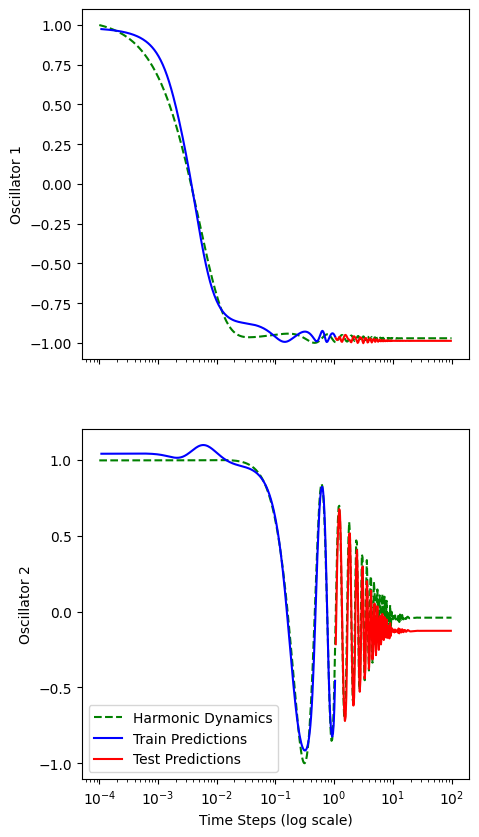

Epoch 101, Train Loss: 0.0073, Test Loss: 0.0116
Epoch 102, Train Loss: 0.0085, Test Loss: 0.0110
Epoch 103, Train Loss: 0.0099, Test Loss: 0.0404
Epoch 104, Train Loss: 0.0077, Test Loss: 0.0131
Epoch 105, Train Loss: 0.0066, Test Loss: 0.0117
Epoch 106, Train Loss: 0.0061, Test Loss: 0.0194
Epoch 107, Train Loss: 0.0084, Test Loss: 0.0159
Epoch 108, Train Loss: 0.0082, Test Loss: 0.0152
Epoch 109, Train Loss: 0.0090, Test Loss: 0.0323
Epoch 110, Train Loss: 0.0079, Test Loss: 0.0141
Epoch 111, Train Loss: 0.0062, Test Loss: 0.0107
Epoch 112, Train Loss: 0.0083, Test Loss: 0.0100
Epoch 113, Train Loss: 0.0102, Test Loss: 0.0450
Epoch 114, Train Loss: 0.0081, Test Loss: 0.0126
Epoch 115, Train Loss: 0.0063, Test Loss: 0.0098
Epoch 116, Train Loss: 0.0058, Test Loss: 0.0187
Epoch 117, Train Loss: 0.0086, Test Loss: 0.0174
Epoch 118, Train Loss: 0.0082, Test Loss: 0.0179
Epoch 119, Train Loss: 0.0092, Test Loss: 0.0275
Epoch 120, Train Loss: 0.0076, Test Loss: 0.0160
Epoch 121, Train Los

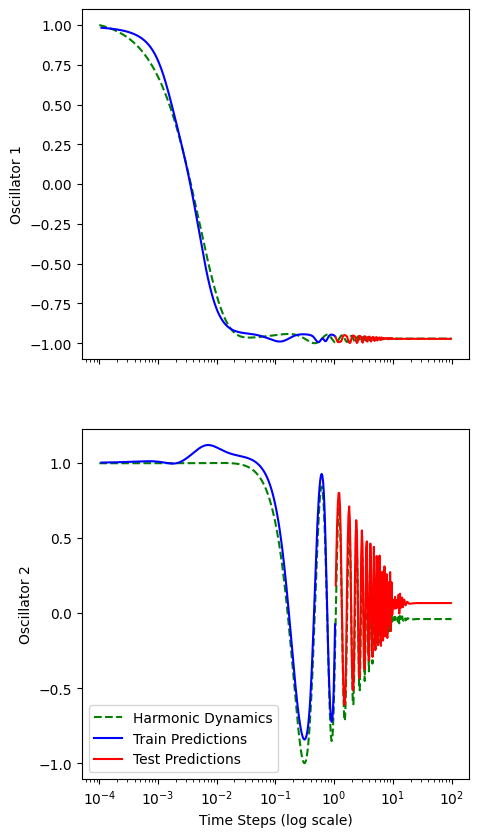

Epoch 201, Train Loss: 0.0046, Test Loss: 0.0057
Epoch 202, Train Loss: 0.0038, Test Loss: 0.0097
Epoch 203, Train Loss: 0.0053, Test Loss: 0.0093
Epoch 204, Train Loss: 0.0054, Test Loss: 0.0154
Epoch 205, Train Loss: 0.0065, Test Loss: 0.0126
Epoch 206, Train Loss: 0.0048, Test Loss: 0.0107
Epoch 207, Train Loss: 0.0041, Test Loss: 0.0067
Epoch 208, Train Loss: 0.0055, Test Loss: 0.0079
Epoch 209, Train Loss: 0.0062, Test Loss: 0.0214
Epoch 210, Train Loss: 0.0050, Test Loss: 0.0065
Epoch 211, Train Loss: 0.0028, Test Loss: 0.0084
Epoch 212, Train Loss: 0.0040, Test Loss: 0.0058
Epoch 213, Train Loss: 0.0056, Test Loss: 0.0201
Epoch 214, Train Loss: 0.0048, Test Loss: 0.0112
Epoch 215, Train Loss: 0.0042, Test Loss: 0.0053
Epoch 216, Train Loss: 0.0035, Test Loss: 0.0094
Epoch 217, Train Loss: 0.0051, Test Loss: 0.0095
Epoch 218, Train Loss: 0.0051, Test Loss: 0.0157
Epoch 219, Train Loss: 0.0062, Test Loss: 0.0109
Epoch 220, Train Loss: 0.0045, Test Loss: 0.0104
Epoch 221, Train Los

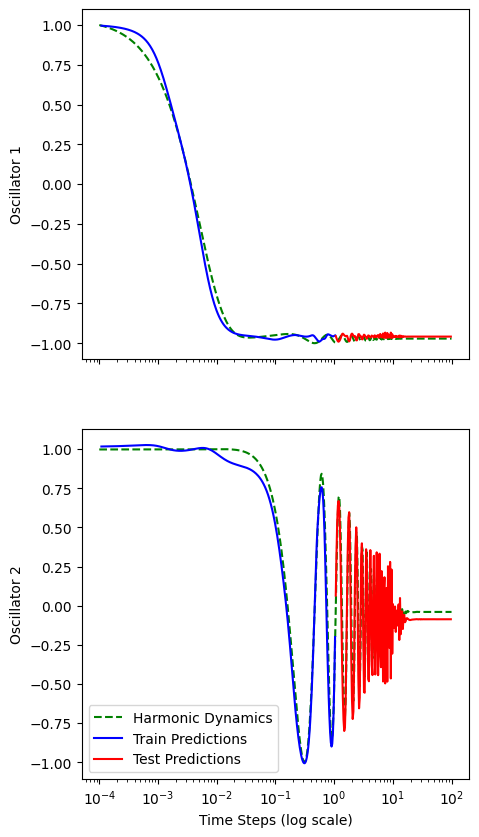

Train MAE OSC 1: 0.0555, Train RMSE OSC 1: 0.0745
Train MAE OSC 2: 0.0410, Train RMSE OSC 2: 0.0547
Test MAE OSC 1: 0.0242, Test RMSE OSC 1: 0.0274
Test MAE OSC 2: 0.1010, Test RMSE OSC 2: 0.1393


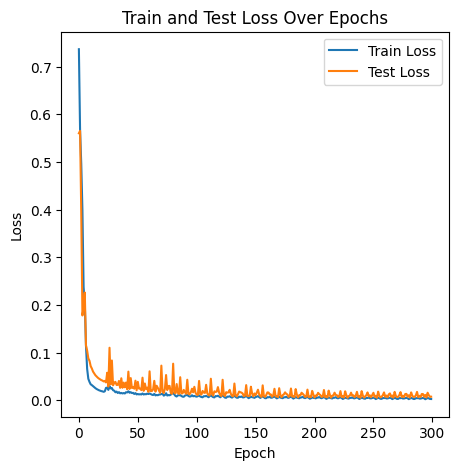

In [5]:
from scipy.integrate import solve_ivp
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Subset

class LSTMTagger(nn.Module):
    def __init__(self, input_size, hidden_dim, sequence_length, n_qubits=0, output_size=1, num_layers=2, backend='default.qubit'):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        if n_qubits > 0:
            print(f"Tagger will use Quantum LSTM running on backend {backend}")
            self.lstm = QLSTM(args.input_size, hidden_dim, n_qubits=n_qubits)
        else:
            print("Tagger will use Classical LSTM")
            self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_timestep_output = lstm_out[:, -1, :]
        fc_out = self.fc(last_timestep_output)
        return fc_out

batch_size = 128

class Args:
    hidden_dim = 4
    n_qubits = 0
    n_epochs = 300
    backend = 'default.qubit'
    learning_rate = 0.01
    sequence_length = 4
    sample_size = 500
    alpha = 0.99
    eps = 1e-8
    input_size = 2

args = Args()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"LSTM hidden layer size: {args.hidden_dim}")
print(f"Number of qubits: {args.n_qubits}")
print(f"Training epochs: {args.n_epochs}")
print(f"Learning rate: {args.learning_rate}")
print(f"RMSprop alpha: {args.alpha}")
print(f"RMSprop eps: {args.eps}")
print(f"sample size: {args.sample_size}")
print(f"sequence length: {args.sequence_length}")
print(f"input size: {args.input_size}")

# Constants for the two coupled damped harmonic oscillators
g = 9.81  # gravitational constant
b1, b2 = 200.0, 0.1 # damping factors
l1, l2 = 1.0, 1.0   # lengths of the pendulums
m1, m2 = 1.0, 1.0  # masses
kc = 100.0 # coupling constant

# Initial conditions
theta1_0, theta2_0 = 0.0, 0.0  # initial angular displacements
theta_dot1_0, theta_dot2_0 = 3.0, 1.0  # initial angular velocities

# Differential equations for the two coupled damped oscillators (as pendulums)
def coupled_damped_pendulums(t, y):
    theta1, theta_dot1, theta2, theta_dot2 = y
    dtheta1_dt = theta_dot1
    dtheta_dot1_dt = -b1/m1 * theta_dot1 - g/l1 * np.sin(theta1) + kc/m1 * (theta2 - theta1)
    dtheta2_dt = theta_dot2
    dtheta_dot2_dt = -b2/m2 * theta_dot2 - g/l2 * np.sin(theta2) + kc/m2 * (theta1 - theta2)
    return [dtheta1_dt, dtheta_dot1_dt, dtheta2_dt, dtheta_dot2_dt]

# Time span and time steps for the simulation using logarithmic spacing
t_span = (1e-4, 1e2)
t_eval = np.logspace(-4, 2, args.sample_size)

# Solve the differential equations
sol = solve_ivp(coupled_damped_pendulums, t_span, [theta1_0, theta_dot1_0, theta2_0, theta_dot2_0], t_eval=t_eval, method='LSODA')

# Extracting the angular velocities
angular_velocity_1 = sol.y[1]
angular_velocity_2 = sol.y[3]

# Normalize the angular velocities
angular_velocity_1_normalized = 2 * (angular_velocity_1 - np.min(angular_velocity_1)) / (np.max(angular_velocity_1) - np.min(angular_velocity_1)) - 1
angular_velocity_2_normalized = 2 * (angular_velocity_2 - np.min(angular_velocity_2)) / (np.max(angular_velocity_2) - np.min(angular_velocity_2)) - 1

angular_velocity_1_min, angular_velocity_1_max = np.min(angular_velocity_1), np.max(angular_velocity_1)
angular_velocity_2_min, angular_velocity_2_max = np.min(angular_velocity_2), np.max(angular_velocity_2)

# Reshape the data for LSTM input
seq_length = 4
num_samples = len(t_eval) - seq_length + 1
input_size = 2  # Two inputs for two oscillators

# Initialize data array
data = np.zeros((num_samples, seq_length, input_size))

# Populate the data array with sequences of angular velocities
for i in range(num_samples):
    data[i, :, 0] = angular_velocity_1_normalized[i:i+seq_length]
    data[i, :, 1] = angular_velocity_2_normalized[i:i+seq_length]

# Convert to a PyTorch tensor
data = torch.tensor(data, dtype=torch.float32)
input_sequences = data[:-1]  # All but the last sequence
labels = data[1:, -1, :]
dataset = TensorDataset(input_sequences, labels)

# Split the data into training and testing sets
train_size = int(0.67 * len(dataset))
test_size = len(dataset) - train_size

train_dataset = Subset(dataset, list(range(train_size)))
test_dataset = Subset(dataset, list(range(train_size, len(dataset))))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = LSTMTagger(input_size=args.input_size, hidden_dim=args.hidden_dim,
                   sequence_length=args.sequence_length, n_qubits=args.n_qubits,
                   output_size=2, backend=args.backend).float()

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=args.learning_rate, alpha=args.alpha, eps=args.eps)

train_losses = []
test_losses = []

for epoch in range(1, args.n_epochs + 1):
    model.train()
    epoch_train_losses = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())

    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)

    model.eval()
    epoch_test_losses = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            epoch_test_losses.append(loss.item())

    avg_test_loss = sum(epoch_test_losses) / len(epoch_test_losses)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

    if epoch in [100, 200, 300]:
        model.eval()
        with torch.no_grad():
            train_preds = [model(batch[0].to(device)) for batch in train_loader]
            test_preds = [model(batch[0].to(device)) for batch in test_loader]

        train_preds = torch.cat(train_preds, dim=0)
        test_preds = torch.cat(test_preds, dim=0)

        x_original = sol.t

        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 10), sharex=True)

        for osc in range(2):  # Oscillator features: 0 for x, 1 for y
            axes[osc].plot(x_original, angular_velocity_1_normalized if osc == 0 else angular_velocity_2_normalized, 'g--', label='Harmonic Dynamics')

            start_index = seq_length - 1
            end_index = start_index + len(train_preds)

            axes[osc].plot(x_original[start_index:end_index], train_preds[:, osc].cpu().numpy(), 'b', label='Train Predictions')

            start_index = end_index
            end_index = start_index + len(test_preds)

            axes[osc].plot(x_original[start_index:end_index], test_preds[:, osc].cpu().numpy(), 'r', label='Test Predictions')

            axes[osc].set_ylabel(f'Oscillator {osc + 1}')

        plt.xlabel('Time Steps (log scale)')
        plt.xscale('log')
        plt.legend()
        plt.show()

# Function to denormalize data
def denormalize(norm_data, original_min, original_max):
    return norm_data * (original_max - original_min) / 2 + (original_max + original_min) / 2

# Final model evaluation
model.eval()
final_train_predictions = []
final_test_predictions = []

with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        final_train_predictions.append(outputs)

    for inputs, labels in test_loader:
        outputs = model(inputs)
        final_test_predictions.append(outputs)

final_train_predictions = torch.cat(final_train_predictions, dim=0)
final_test_predictions = torch.cat(final_test_predictions, dim=0)

train_labels = torch.cat([label for _, label in train_loader], dim=0)
test_labels = torch.cat([label for _, label in test_loader], dim=0)

train_labels_np = train_labels.cpu().numpy()
test_labels_np = test_labels.cpu().numpy()
final_train_predictions_np = final_train_predictions.cpu().numpy()
final_test_predictions_np = final_test_predictions.cpu().numpy()

train_labels_x = denormalize(train_labels_np[:, 0], angular_velocity_1_min, angular_velocity_1_max)
train_labels_y = denormalize(train_labels_np[:, 1], angular_velocity_2_min, angular_velocity_2_max)
test_labels_x = denormalize(test_labels_np[:, 0], angular_velocity_1_min, angular_velocity_1_max)
test_labels_y = denormalize(test_labels_np[:, 1], angular_velocity_2_min, angular_velocity_2_max)

final_train_predictions_x = denormalize(final_train_predictions_np[:, 0], angular_velocity_1_min, angular_velocity_1_max)
final_train_predictions_y = denormalize(final_train_predictions_np[:, 1], angular_velocity_2_min, angular_velocity_2_max)
final_test_predictions_x = denormalize(final_test_predictions_np[:, 0], angular_velocity_1_min, angular_velocity_1_max)
final_test_predictions_y = denormalize(final_test_predictions_np[:, 1], angular_velocity_2_min, angular_velocity_2_max)

def calculate_metrics(true_labels_np, predictions_np):
    mae = mean_absolute_error(true_labels_np, predictions_np)
    rmse = np.sqrt(mean_squared_error(true_labels_np, predictions_np))
    return mae, rmse

train_mae_x, train_rmse_x = calculate_metrics(train_labels_x, final_train_predictions_x)
train_mae_y, train_rmse_y = calculate_metrics(train_labels_y, final_train_predictions_y)
test_mae_x, test_rmse_x = calculate_metrics(test_labels_x, final_test_predictions_x)
test_mae_y, test_rmse_y = calculate_metrics(test_labels_y, final_test_predictions_y)

print(f'Train MAE OSC 1: {train_mae_x:.4f}, Train RMSE OSC 1: {train_rmse_x:.4f}')
print(f'Train MAE OSC 2: {train_mae_y:.4f}, Train RMSE OSC 2: {train_rmse_y:.4f}')
print(f'Test MAE OSC 1: {test_mae_x:.4f}, Test RMSE OSC 1: {test_rmse_x:.4f}')
print(f'Test MAE OSC 2: {test_mae_y:.4f}, Test RMSE OSC 2: {test_rmse_y:.4f}')

plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Train and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [6]:
import numpy as np

# Parameters
g = 9.81  # gravitational constant
b1 = 200.0  # large damping factor for the first oscillator
b2 = 0.1  # moderate damping factor for the second oscillator
l1, l2 = 1.0, 1.0  # lengths of the pendulums
m1, m2 = 1.0, 1.0  # masses
kc = 100.0  # large coupling constant to introduce stiffness

# Jacobian matrix
J = np.array([
    [0, 1, 0, 0],
    [-(kc/m1 + g/l1), -b1/m1, kc/m1, 0],
    [0, 0, 0, 1],
    [kc/m2, 0, -(kc/m2 + g/l2), -b2/m2]
])

# Compute eigenvalues
eigenvalues = np.linalg.eigvals(J)
print("Eigenvalues:", eigenvalues)

# Compute stiffness ratio using real parts
real_parts = np.real(eigenvalues)
non_zero_real_parts = real_parts[real_parts != 0]
stiffness_ratio_real = np.max(np.abs(non_zero_real_parts)) / np.min(np.abs(non_zero_real_parts))
print("Stiffness Ratio (Real Parts):", stiffness_ratio_real)



Eigenvalues: [-1.99450695e+02 +0.j         -2.77772512e-01+10.48744476j
 -2.77772512e-01-10.48744476j -9.37595912e-02 +0.j        ]
Stiffness Ratio (Real Parts): 2127.2564532879073
